# Initialization

I imported pytorch here ... if you're more familiar with TF/Keras/Theano/etc, let's import those libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.io as sio
from scipy.stats import kurtosis
from scipy import signal
from sklearn.model_selection import train_test_split
from  sklearn.utils import shuffle
from os import path, mkdir
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as utils
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import itertools
import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib import colors as mcolors
import urllib.request

# Downloading the Data
In this part we download the raw data from the online repository.

In [ ]:
def make_dir(dir):
  if not path.exists(dir):
      mkdir(dir)
      print(dir + ' is created!')
  else: print(dir + ' exists!')
  return 

data_dir = '/content/data/'
make_dir(data_dir)


/content/data/ is created!


In [ ]:
data_codes = {'97': {'class':0, 'rpm':1797}, '98':{'class':0, 'rpm':1772}, '99':{'class':0, 'rpm':1750}, '100': {'class':0, 'rpm':1730},
              '105':{'class':1, 'rpm':1797}, '106':{'class':1, 'rpm':1772}, '107':{'class':1, 'rpm':1750}, '108':{'class':1, 'rpm':1730},
              '209':{'class':1, 'rpm':1797}, '210':{'class':1, 'rpm':1772}, '211':{'class':1, 'rpm':1750}, '212':{'class':1, 'rpm':1730},
              '118':{'class':2, 'rpm':1797}, '120':{'class':2, 'rpm':1750}, '121':{'class':2, 'rpm':1730},
              '130':{'class':3, 'rpm':1797}, '131':{'class':3, 'rpm':1772}, '132':{'class':3, 'rpm':1750},
              '156':{'class':5, 'rpm':1797}, '158':{'class':5, 'rpm':1772}, '159':{'class':5, 'rpm':1750}, '160':{'class':5, 'rpm':1730},
              '198':{'class':3, 'rpm':1772}, '199':{'class':3, 'rpm':1750}, 
              '144':{'class':4, 'rpm':1797}, '145':{'class':4, 'rpm':1772}, '146':{'class':4, 'rpm':1750},} # keys: data codes in CWRU website  [IT'S ONLY SOME OF THE WHOLE DATA]

dir = []

for k,v in data_codes.items():
  print('k =', k, ' | ', v)
  if path.isfile(data_dir + k + '.mat'): pass  # if it is already downloaded
  else:
    urllib.request.urlretrieve(f"http://engineering.case.edu/sites/default/files/{k}.mat",
                               data_dir + k + '.mat')
  
  data = scipy.io.loadmat(data_dir + k + '.mat')
  if len(k) == 2: k_3 = '0'+k
  elif len(k) == 3: k_3 = k
  de = f'X{k_3}_DE_time'
  fe = f'X{k_3}_FE_time'
  dir.append([data_dir + k + '.mat' ,de, fe, v])
print('=== download complete! ===')

k = 97  |  {'class': 0, 'rpm': 1797}
k = 98  |  {'class': 0, 'rpm': 1772}
k = 99  |  {'class': 0, 'rpm': 1750}
k = 100  |  {'class': 0, 'rpm': 1730}
k = 105  |  {'class': 1, 'rpm': 1797}
k = 106  |  {'class': 1, 'rpm': 1772}
k = 107  |  {'class': 1, 'rpm': 1750}
k = 108  |  {'class': 1, 'rpm': 1730}
k = 209  |  {'class': 1, 'rpm': 1797}
k = 210  |  {'class': 1, 'rpm': 1772}
k = 211  |  {'class': 1, 'rpm': 1750}
k = 212  |  {'class': 1, 'rpm': 1730}
k = 118  |  {'class': 2, 'rpm': 1797}
k = 120  |  {'class': 2, 'rpm': 1750}
k = 121  |  {'class': 2, 'rpm': 1730}
k = 130  |  {'class': 3, 'rpm': 1797}
k = 131  |  {'class': 3, 'rpm': 1772}
k = 132  |  {'class': 3, 'rpm': 1750}
k = 156  |  {'class': 5, 'rpm': 1797}
k = 158  |  {'class': 5, 'rpm': 1772}
k = 159  |  {'class': 5, 'rpm': 1750}
k = 160  |  {'class': 5, 'rpm': 1730}
k = 198  |  {'class': 3, 'rpm': 1772}
k = 199  |  {'class': 3, 'rpm': 1750}
k = 144  |  {'class': 4, 'rpm': 1797}
k = 145  |  {'class': 4, 'rpm': 1772}
k = 146  |  {'c

# Dataset generating
In this section we have to randomly collect samples and make a dataset which then can be split to "train", "test" and "val". # THE test SET SHOULDN'T HAVE ANY OVERLAP WITH THE train/val SETS.

In [ ]:
length = 400  # the window (number of timestamps in each sample)
snr = False  # Signal to Noise Ratio (a number - if "False": no noise should be added)
test_size = 0.2  # ratio of test set to the whole (between 0 and 1)
val_size = 0.1  # ratio of val set to the whole (between 0 and 1)
file_name = f'cwru{length}snr{int(snr)}.npz'

In [ ]:
# <<Maryam>> provides a script that generates the dataset --- please add adequate comments at each line
# use this tool which is previously imported: train_test_split -- you can use it twice to make train/test/val sets... I'm adding an example below:
"""
X_train, X_test, y_train, y_test 
    = train_test_split(X, y, test_size=test_size, random_state=436)

 X_train, X_val, y_train, y_val 
    = train_test_split(X_train, y_train, test_size=val_size/(1-test_size), random_state=537) # .1 x (1-.2) = .125 of the train set = .1 of the whole
"""


#Data Preprocessing

Feature extraction, Signal processing, dimension reduction (possibly!), denoising (if needed)  -- These features may be used in different architectures provided in the next section.

this is a sample picker to just have a sample to see if the preprocessing techniques work.

(500, 1)


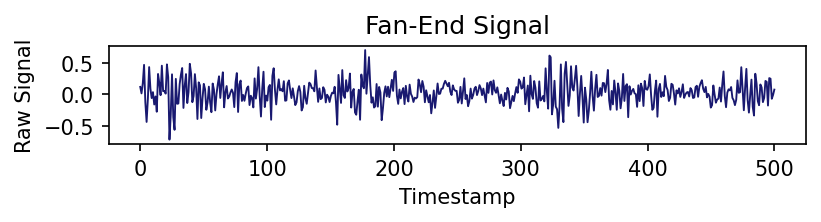

In [ ]:
k = '211'
data = scipy.io.loadmat(data_dir + k + '.mat')
if len(k) == 2: k_3 = '0'+k
elif len(k) == 3: k_3 = k
de = f'X{k_3}_DE_time'
fe = f'X{k_3}_FE_time'

length = 500

t = np.linspace(start=0, stop=length, num=length)
start = np.random.randint(low=0, high=50000)
signal_de = data[de][start:start+len(t)]
signal_fe = data[fe][start:start+len(t)]

Signal, name = signal_fe, 'Fan-End Signal'
c='midnightblue'
lw=0.9
print(Signal.shape)
plt.figure(1, dpi=150)
plt.subplot(4,1,1)
plt.plot(t, Signal, c=c, lw=lw)
plt.title(name)
plt.ylabel('Raw Signal')
plt.xlabel('Timestamp')
plt.show()

## EMD (classes and functions)

In [ ]:
# <<Seyi>> provides some signal processing feature extraction techniques here

In [ ]:
# EEMD:


In [ ]:
# <<Mass>> provides some visualizations

# DL Architectures

We develop some state-of-the-art as well as classic architectures here to compare their performance on the dataset.

## Some architectures from the literature

In [ ]:
# <<Ardeshir>> <<Todd>> <<Maryam>> <<Mass>> provide the architectures here

## The proposed architectures (ours)

In [ ]:
# Let's be innovative enough!

#Model training

Here based on different RPMs, SNRs and Imbalanced severity, we have different datasets; We need to take an architecture and train it on a given dataset.
Inputs: [DL model] [dataset] [dataset condition] [hyperparameters]

Don't forget to save the trained model somewhere on the google drive (plus its runtime with GPU/CPU info and parameters) -- we don't want to run one model over and over.

In [ ]:
# a script that takes an architecture and trains it on a given dataset (the conditions can be different based on the SNR or imbalanced situation)

## Rolling Element Bearing Fault Detection Using Deep Learning
By: Alex Shenfield and Martin Howarth 

https://github.com/al3xsh/rolling-element-bearing-fault-detection

In [ ]:
!git clone https://github.com/al3xsh/rolling-element-bearing-fault-detection.git

In [ ]:
!rm /content/rolling-element-bearing-fault-detection/keras/rnn-wdcnn/utils
!ln -s /content/rolling-element-bearing-fault-detection/keras/utils /content/rolling-element-bearing-fault-detection/keras/rnn-wdcnn/utils
!ln -s /content/rolling-element-bearing-fault-detection/utils/data /content/rolling-element-bearing-fault-detection/keras/rnn-wdcnn/utils/data

In [ ]:
# Requires older versions of tensorflow and keras
!pip install keras==2.3.1
!pip install tensorflow==2.1
# Make sure to restart the runtime after running this cell!

In [ ]:
#Check versions are correct!
import tensorflow
import keras
print('Tensorflow Version:', tensorflow.__version__)
print('Keras Version:', keras.__version__)

In [ ]:
!python /content/rolling-element-bearing-fault-detection/keras/rnn-wdcnn/train_rnn_wdcnn_loads.py -n_epochs=25 -batch_size=8 -clr_method=triangular2 -base_lr=1e-5 -max_lr=1e-3 -step_size=26367 -rnn_type=lstm -n_cells=128 -kernel_size=256 -recurrent_dropout=0.1 -data_path=../../data/ -source=1 -target=2 -target=3

Using TensorFlow backend.
1633740058.7284913
loading data ...
Traceback (most recent call last):
  File "/content/rolling-element-bearing-fault-detection/keras/rnn-wdcnn/train_rnn_wdcnn_loads.py", line 108, in <module>
    normalisation=normalisation)
  File "/content/rolling-element-bearing-fault-detection/keras/rnn-wdcnn/utils/data/cwru_data_loader.py", line 116, in __init__
    '{0}hp'.format(l)).iterdir()))
  File "/usr/lib/python3.7/pathlib.py", line 1107, in iterdir
    for name in self._accessor.listdir(self):
FileNotFoundError: [Errno 2] No such file or directory: '../../data/48k_normal_baseline/1hp'


In [ ]:
!python /content/rolling-element-bearing-fault-detection/keras/rnn-wdcnn/train_rnn_wdcnn_snr.py -n_epochs=25 -batch_size=8 -clr_method=triangular2 -base_lr=1e-5 -max_lr=1e-3 -step_size=26367 -rnn_type=lstm -n_cells=128 -kernel_size=256 -recurrent_dropout=0.1 -data_path=../../data/

Using TensorFlow backend.
1633740075.399262
loading data ...
Traceback (most recent call last):
  File "/content/rolling-element-bearing-fault-detection/keras/rnn-wdcnn/train_rnn_wdcnn_snr.py", line 97, in <module>
    normalisation=normalisation)
  File "/content/rolling-element-bearing-fault-detection/keras/rnn-wdcnn/utils/data/cwru_data_loader.py", line 116, in __init__
    '{0}hp'.format(l)).iterdir()))
  File "/usr/lib/python3.7/pathlib.py", line 1107, in iterdir
    for name in self._accessor.listdir(self):
FileNotFoundError: [Errno 2] No such file or directory: '../../data/48k_normal_baseline/1hp'


# Model testing

Obviously we gotta check out the model performance. So, here we go...

In [ ]:
# a script that evaluates the performance of the model on the test set. 

# Performance comparison

Visualize the performance of each model in different conditions.

In [ ]:
# <<Mass>> <<Todd>> <<Ardeshir>> <<Maryam>> provide some visualization ideas here